# Classifying Ishihara Plates (colorblind tests) Using A Deep Neural Network
> Atuhor: Hannan Khan  
> Last Updated: 2022-04-07 06:37:43

# Loading Libraries

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gc

from torchsummary import summary

from ipywidgets import IntProgress
from IPython.display import display, clear_output

from tqdm.notebook import tqdm


torch.cuda.empty_cache()

# Loading The Dataset

In [2]:
dataset_dir = r'D:\Datasets\Ishihara_Numbers\augmented_numbers_imgs_96_noShiftAugmentations_dark'
train_dir = os.sep.join([dataset_dir, 'train'])
test_dir = os.sep.join([dataset_dir, 'test'])
models_dir = 'models'
classes = [str(x) for x in range(10)]
BATCH_SIZE = 32
IMG_SIZE = (96,96)
NUM_CHANNELS = 3

We will initialize the datasets next.

In [3]:
class ZeroOutWhiteSpace(object):
    def __call__(self, sample):
        image = sample
        
        channels = image.shape[0]
        height, width = image.shape[1], image.shape[2]
        
        for i in range(height):
            for j in range(width):
                # if all channel values are 1
                if image[0,i,j]==1 and image[1,i,j]==1 and image[2,i,j]==1:
                    for channel in range(channels):
                        image[channel,i,j] = 0.0

        return image

We split our train dataset (4480 samples) into 90% training and 10% validation dataset (4032, 448).

In [4]:
# tensor_transform = transforms.Compose([transforms.ToTensor(), ZeroOutWhiteSpace()])
tensor_transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# tensor_transform = transforms.ToTensor()

train_dataset = ImageFolder(root = train_dir, transform = tensor_transform)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, (4032, 448))
test_dataset = ImageFolder(root = test_dir, transform = tensor_transform)

print("Train Num Samples:", len(train_dataset))
print("Val Num Samples:", len(val_dataset))
print("Test Num Samples:", len(test_dataset))

Train Num Samples: 4032
Val Num Samples: 448
Test Num Samples: 1120


In [5]:
train_dataset[0][0]

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

Now, we will create dataloader objects to more efficiently feed data into our model.

In [6]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True,num_workers=3, persistent_workers=True)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, persistent_workers=True)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle = True,num_workers=3, persistent_workers=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


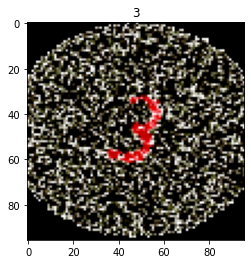

In [7]:
visualize_batch = train_dataset[5]
plt.title(str(visualize_batch[1]))
plt.imshow(np.transpose(visualize_batch[0].numpy(), (1, 2, 0)))

# Investigating The Effects Of Pooling
The model is getting fed a number that is essentially broken up into little circles. In order to get a better picture of the number present in the image, we can apply a form of pooling.  
Below is the code to see the effects of various poolings on our sample image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


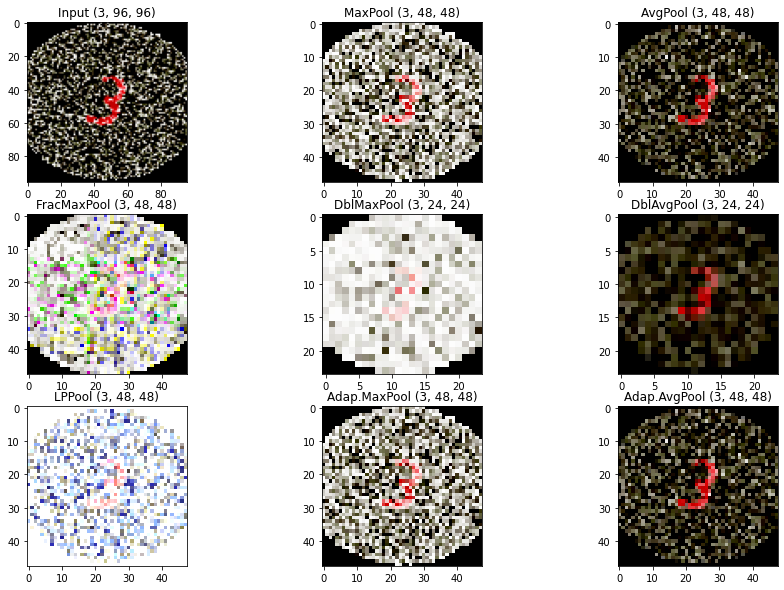

In [8]:
max_pool = nn.MaxPool2d(2,2)
max_batch = max_pool(visualize_batch[0])
max_batch_2 = max_pool(max_batch)
avg_pool = nn.AvgPool2d(2,2)
avg_batch = avg_pool(visualize_batch[0])
avg_batch_2 = avg_pool(avg_batch)
frac_max_pool = nn.FractionalMaxPool2d(3, 48)
frac_max_batch = frac_max_pool(visualize_batch[0])
lp_pool = nn.LPPool2d(2,2,stride=2)
lp_batch = lp_pool(visualize_batch[0])
adap_max_pool = nn.AdaptiveMaxPool2d(48)
adap_max_batch = adap_max_pool(visualize_batch[0])
adap_avg_pool = nn.AdaptiveAvgPool2d(48)
adap_avg_batch = adap_avg_pool(visualize_batch[0])

fig, axes = plt.subplots(3,3, figsize=(15,10))

axes[0][1].set_title(f"MaxPool {tuple(max_batch.shape)}")
axes[0][1].imshow(np.transpose(max_batch, (1,2,0)))
axes[0][2].set_title(f"AvgPool {tuple(avg_batch.shape)}")
axes[0][2].imshow(np.transpose(avg_batch, (1,2,0)))
axes[0][0].set_title(f"Input {tuple(visualize_batch[0].shape)}")
axes[0][0].imshow(np.transpose(visualize_batch[0], (1,2,0)))

axes[1][1].set_title(f"DblMaxPool {tuple(max_batch_2.shape)}")
axes[1][1].imshow(np.transpose(max_batch_2, (1,2,0)))
axes[1][2].set_title(f"DblAvgPool {tuple(avg_batch_2.shape)}")
axes[1][2].imshow(np.transpose(avg_batch_2, (1,2,0)))
axes[1][0].set_title(f"FracMaxPool {tuple(frac_max_batch.shape)}")
axes[1][0].imshow(np.transpose(frac_max_batch, (1,2,0)))

axes[2][0].set_title(f"LPPool {tuple(lp_batch.shape)}")
axes[2][0].imshow(np.transpose(lp_batch, (1,2,0)))
axes[2][1].set_title(f"Adap.MaxPool {tuple(adap_max_batch.shape)}")
axes[2][1].imshow(np.transpose(adap_max_batch, (1,2,0)))
axes[2][2].set_title(f"Adap.AvgPool {tuple(adap_avg_batch.shape)}")
axes[2][2].imshow(np.transpose(adap_avg_batch, (1,2,0)))

# Creating A Model

We will be using the Optuna library, and conducting our model search via that.

In [18]:
# set up GPU if available.
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
    gc.collect()
    torch.cuda.empty_cache()

layers = []
layers.append(nn.Conv2d(3, 64, 2))
layers.append(nn.BatchNorm2d(64, momentum=0.9))
layers.append(nn.ReLU())
layers.append(nn.MaxPool2d(3, 3))
layers.append(nn.Conv2d(64, 64, 3))
layers.append(nn.BatchNorm2d(64, momentum=0.9))
layers.append(nn.ReLU())
layers.append(nn.MaxPool2d(3, 3))
layers.append(nn.Flatten())
layers.append(nn.Linear(64*9*9, 512))
layers.append(nn.ReLU())
layers.append(nn.Linear(512, 256))
layers.append(nn.ReLU())
layers.append(nn.Linear(256, 128))
layers.append(nn.ReLU())
layers.append(nn.Linear(128, 64))
layers.append(nn.ReLU())
layers.append(nn.Linear(64, 10))
layers.append(nn.Softmax(dim=1))

cnn_model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=.05)

In [19]:
summary(cnn_model, (NUM_CHANNELS, IMG_SIZE[0], IMG_SIZE[0]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 95, 95]             832
       BatchNorm2d-2           [-1, 64, 95, 95]             128
              ReLU-3           [-1, 64, 95, 95]               0
         MaxPool2d-4           [-1, 64, 31, 31]               0
            Conv2d-5           [-1, 64, 29, 29]          36,928
       BatchNorm2d-6           [-1, 64, 29, 29]             128
              ReLU-7           [-1, 64, 29, 29]               0
         MaxPool2d-8             [-1, 64, 9, 9]               0
           Flatten-9                 [-1, 5184]               0
           Linear-10                  [-1, 512]       2,654,720
             ReLU-11                  [-1, 512]               0
           Linear-12                  [-1, 256]         131,328
             ReLU-13                  [-1, 256]               0
           Linear-14                  [

In [20]:
epochs = 500

pbar = tqdm(range(epochs))
pbar.set_description("Epochs")
train_bar = tqdm(total=len(train_data_loader), desc="Training")
val_bar = tqdm(total=len(test_data_loader), desc="Validating")

batch_accuracies = []
batch_train_losses = []
batch_val_losses = []
epoch_accuracies = []
epoch_train_losses = []
epoch_val_losses = []

for epoch in pbar:  # loop over the dataset multiple times
    cnn_model.train()

    train_loss = 0.0
    test_loss = 0.0
    correct = 0
    total = 0
    acc = 0
    
    train_bar.refresh()
    train_bar.reset()
    val_bar.refresh()
    val_bar.reset()
    
    for i, data in enumerate(train_data_loader):
        train_bar.update()
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = cnn_model(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        # delete inputs and labels to free up memory
        del inputs, labels

        # print statistics
        train_loss = loss.item()
        batch_train_losses.append(train_loss)
        train_bar.set_postfix_str(f'loss={train_loss:.5f}')
    
    epoch_train_losses.append(batch_train_losses[-1])

    # We don't need gradients on to do reporting
    cnn_model.train(False)
    
    for i, vdata in enumerate(val_data_loader):
        val_bar.update()
        vinputs, vlabels = vdata
        voutputs = cnn_model(vinputs.to(device))
        _, predicted = torch.max(voutputs.data, 1)
        vloss = criterion(voutputs, vlabels.to(device))
        test_loss = vloss.item()
        batch_val_losses.append(test_loss)
        total += vlabels.size(0)
        correct += (predicted == vlabels.to(device)).sum().item()
        acc = correct/total*100
        batch_accuracies.append(acc)
        val_bar.set_postfix_str(f'acc={acc:.2f}, vloss={test_loss:.5f}')
    
    epoch_val_losses.append(batch_val_losses[-1])
    epoch_accuracies.append(np.average(batch_accuracies))

    pbar.set_postfix_str(f'avg_acc={np.average(batch_accuracies):.2f}, \
                           avg_loss={np.average(batch_train_losses):.4f}, \
                         avg_vloss={np.average(batch_val_losses):.4f}')

print('Finished Training')

  0%|          | 0/500 [00:00<?, ?it/s]

Training:   0%|          | 0/126 [00:00<?, ?it/s]

Validating:   0%|          | 0/35 [00:00<?, ?it/s]

Finished Training


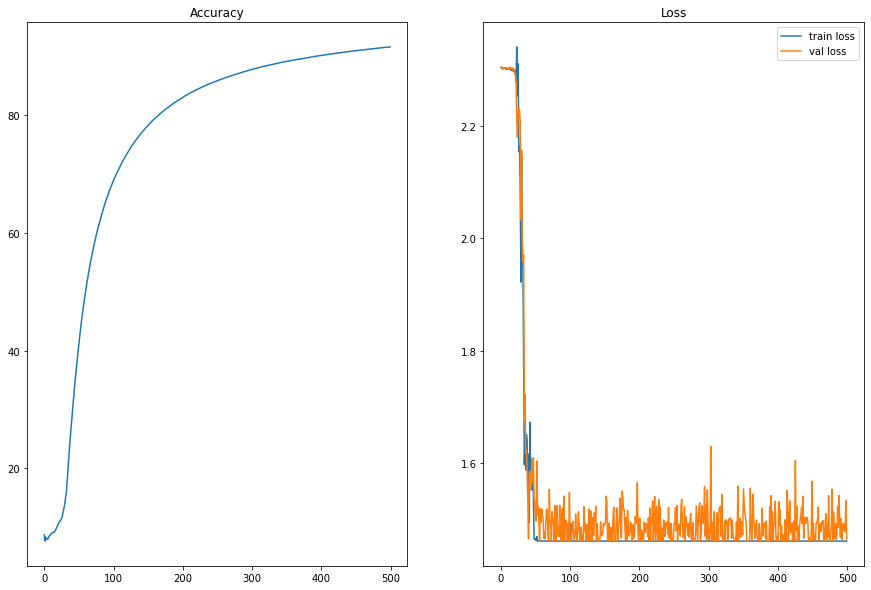

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

ax1.set_title("Accuracy")
ax1.plot(range(epochs), epoch_accuracies)
ax2.set_title("Loss")
ax2.plot(range(epochs), epoch_train_losses, label = "train loss")
ax2.plot(range(epochs), epoch_val_losses, label = "val loss")
ax2.legend()
plt.show()

In [22]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.title("Ground Truth")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_data_loader)

torch.Size([3, 96, 96])


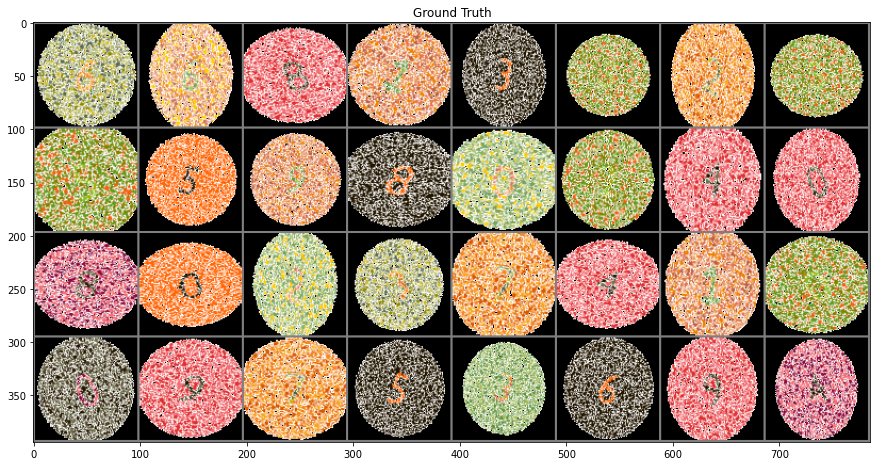

In [23]:
images, labels = dataiter.next()
print(images[0].shape)

imshow(torchvision.utils.make_grid(images))

In [24]:
pred = cnn_model(images.to(device))
# print(pred)
_, predicted = torch.max(pred, 1)

print('Groundtruth|Predicted')
for j in range(0, 32, 2):
    print(f'{classes[labels[j]]}|{classes[predicted[j]]}\t{classes[labels[j+1]]}|{classes[predicted[j+1]]}')

Groundtruth|Predicted
6|6	6|6
8|8	1|1
3|3	3|3
2|2	3|3
5|5	5|5
9|9	8|8
0|0	2|2
4|4	0|0
8|8	0|0
2|2	3|3
7|7	4|4
1|1	0|0
0|0	9|9
7|7	5|5
3|3	6|6
9|9	4|4


In [25]:
from sklearn.metrics import accuracy_score

accuracy_bar = tqdm(test_data_loader, desc="Evaluating")

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i, data in enumerate(accuracy_bar):
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn_model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()
        accuracy_bar.set_postfix({'correct': correct, 'wrong': total-correct, 'total': total})

print(f'Accuracy of the network: {100 * correct // total} %')

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Accuracy of the network: 99 %


Saving the model:

In [26]:
curr_model_name = 'model_1.1_99_test_acc'
curr_model_dir = os.sep.join([models_dir, curr_model_name])

if not os.path.exists(curr_model_dir):
    os.mkdir(curr_model_dir)
torch.save(cnn_model.state_dict(), os.sep.join([curr_model_dir, 'model_weights.pth']))
torch.save(cnn_model, os.sep.join([curr_model_dir, 'model.pth']))

print(f"Model and weights saved to: {curr_model_dir}")

Model and weights saved to: models\model_1.1_99_test_acc
